In [916]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy.typing as npt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import xgboost as xgb

In [917]:
# constants

RANDOM_STATE: np.int8 = 42
TEST_SIZE: np.float64 = 0.2

MAXIMUM_UNIT_LENGTH_STAY: np.int32 = 24
NUMBER_OF_BINS: np.int8 = 2

In [918]:
# getting data from comorbidades and capacidade funcional, plus ages and labels
df: pd.DataFrame = pd.read_csv("data/raw/folha3.csv")
ages: pd.Series = df["Age"].copy()
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
labels: pd.DataFrame = df["UnitLengthStay"].copy()
df = df.iloc[:, 22:]
sheet_3_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from motivos de internação na UTI
df = pd.read_csv("data/raw/folha4.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_4_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

# getting data from dados fisiologicos na UTI
df = pd.read_csv("data/raw/folha6.csv")
df: pd.DataFrame = df[df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)].copy()
df = df.iloc[:, 21:]
df.dropna(axis=1, thresh=5000, inplace=True)
df.fillna(value=0, inplace=True)
sheet_6_df: pd.DataFrame = df.copy()

# joining dataframes
final_data: pd.DataFrame = pd.concat([ages, sheet_3_df, sheet_4_df, sheet_6_df], axis=1, join="inner")

labels_regression: pd.DataFrame = labels.copy()
labels_classification: pd.DataFrame = pd.cut(x=labels_regression, bins=[0, 2, MAXIMUM_UNIT_LENGTH_STAY], labels=np.arange(NUMBER_OF_BINS))

In [927]:
final_data.to_csv("data/processed/final_data.csv")

# REGRESSION

In [919]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data, labels_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
NUMBER_OF_ESTIMATORS: np.int32 = 400

In [920]:
model = RandomForestRegressor(n_estimators=NUMBER_OF_ESTIMATORS)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

11.156409261520757

In [921]:
model = xgb.XGBRegressor(n_estimators=NUMBER_OF_ESTIMATORS)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

13.096367385874652

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

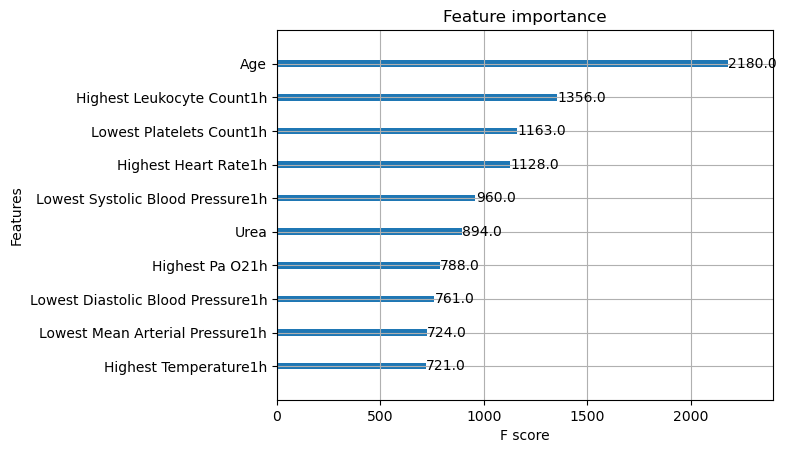

In [922]:
xgb.plot_importance(booster=model, max_num_features=10)

# CLASSIFICATION

In [923]:
X_train, X_test, y_train, y_test = train_test_split(
    final_data, labels_classification, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
NUMBER_OF_ESTIMATORS: np.int32 = 400

In [924]:
model = xgb.XGBClassifier(n_estimators=NUMBER_OF_ESTIMATORS, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.6357827476038338

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

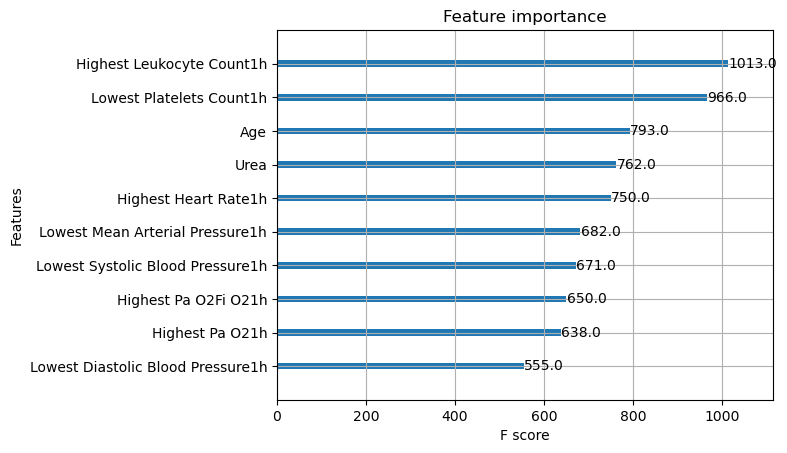

In [925]:
xgb.plot_importance(booster=model, max_num_features=10)